# Задача:

1. Загрузить набор данных, bots_vs_users.csv для задачи классификации user:0 ; bot:1.

2. Разделить данные на обучающую и тестовую выборки с помощью функции train_test_split из библиотеки scikit-learn.

3. Создайте модель машинного обучения, которую вы хотите использовать для предсказания на этом наборе данных. Например, можно использовать модель линейной регрессии или случайный лес для задачи регрессии, или модель логистической регрессии или случайный лес для задачи классификации.

4. Используйте метод кросс-валидации, чтобы оценить производительность модели на обучающей выборке. Например, можно использовать метод cross_val_score из библиотеки scikit-learn с использованием метрики оценки, такой как точность (accuracy) или среднеквадратичная ошибка (mean squared error).

5. Провести подбор гиперпараметров модели с помощью метода GridSearchCV из библиотеки scikit-learn. Этот метод позволяет перебирать различные значения гиперпараметров и выбирать наилучшие значения на основе кросс-валидации.

6. Обучить модель с использованием оптимальных гиперпараметров на обучающей выборке и оцените ее производительность на тестовой выборке.

7. Проведите анализ результатов и сделайте выводы о процессе кросс-валидации и подборе гиперпараметров в задачах машинного обучения.

#Решаем задачу предсказания переходов клиентов к другому оператору

In [315]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
import plotly.graph_objects as go
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE


In [316]:
df=pd.read_csv('bots_vs_users.csv')
df.head()

,has_domain,has_birth_date,has_photo,can_post_on_wall,can_send_message,has_website,gender,has_short_name,has_first_name,has_last_name,...,ads_ratio,avg_views,posting_frequency_days,phone_numbers_ratio,avg_text_uniqueness,city,has_occupation,occupation_type_university,occupation_type_work,has_personal_data
0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,Unknown,Unknown,Unknown,Unknown,Unknown
1,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,Unknown,Unknown,Unknown,Unknown,Unknown
2,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,Unknown,Unknown,Unknown,Unknown,Unknown
3,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,Unknown,Unknown,Unknown,Unknown,Unknown
4,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,Unknown,Unknown,Unknown,Unknown,Unknown


In [317]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5874 entries, 0 to 5873
Data columns (total 60 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   has_domain                  5874 non-null   object 
 1   has_birth_date              5874 non-null   object 
 2   has_photo                   5874 non-null   object 
 3   can_post_on_wall            5874 non-null   object 
 4   can_send_message            5874 non-null   object 
 5   has_website                 5874 non-null   object 
 6   gender                      5874 non-null   object 
 7   has_short_name              5874 non-null   object 
 8   has_first_name              5874 non-null   object 
 9   has_last_name               5874 non-null   object 
 10  access_to_closed_profile    5874 non-null   object 
 11  is_profile_closed           5874 non-null   object 
 12  target                      5874 non-null   int64  
 13  has_nickname                5874 

In [318]:

for col in ['has_occupation', 'occupation_type_university','occupation_type_work', 'has_personal_data']:
    print(col, df[col].unique() )

has_occupation ['Unknown' '1.0']
occupation_type_university ['Unknown' '0.0' '1.0']
occupation_type_work ['Unknown' '1.0' '0.0']
has_personal_data ['Unknown' '1.0']


Проводим первичную обработку данных

In [319]:
# Предварительная обработка данных
df=df.replace({'Unknown': '0'})
df.fillna(0, inplace=True)
le=LabelEncoder()
df['city']=le.fit_transform(df['city'])

for col in df.columns:
    if df[col].dtype == 'object':
        df[col]=pd.to_numeric(df[col], errors='coerce')

df.head()

,has_domain,has_birth_date,has_photo,can_post_on_wall,can_send_message,has_website,gender,has_short_name,has_first_name,has_last_name,...,ads_ratio,avg_views,posting_frequency_days,phone_numbers_ratio,avg_text_uniqueness,city,has_occupation,occupation_type_university,occupation_type_work,has_personal_data
0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
1,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
2,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
3,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
4,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0


In [320]:
df['target'].dtype

dtype('int64')

In [321]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5874 entries, 0 to 5873
Data columns (total 60 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   has_domain                  5874 non-null   float64
 1   has_birth_date              5874 non-null   float64
 2   has_photo                   5874 non-null   float64
 3   can_post_on_wall            5874 non-null   float64
 4   can_send_message            5874 non-null   float64
 5   has_website                 5874 non-null   float64
 6   gender                      5874 non-null   float64
 7   has_short_name              5874 non-null   float64
 8   has_first_name              5874 non-null   float64
 9   has_last_name               5874 non-null   float64
 10  access_to_closed_profile    5874 non-null   float64
 11  is_profile_closed           5874 non-null   float64
 12  target                      5874 non-null   int64  
 13  has_nickname                5874 

In [322]:
df.isna().sum()

,0
has_domain,0
has_birth_date,0
has_photo,0
can_post_on_wall,0
can_send_message,0
has_website,0
gender,0
has_short_name,0
has_first_name,0
has_last_name,0


*Пропущенных значений - нет*

In [323]:
for col in df.columns:
    print(col, df[col].unique())

has_domain [1. 0.]
has_birth_date [1. 0.]
has_photo [0. 1.]
can_post_on_wall [0. 1.]
can_send_message [0. 1.]
has_website [0. 1.]
gender [1. 2. 0.]
has_short_name [1. 0.]
has_first_name [1. 0.]
has_last_name [1. 0.]
access_to_closed_profile [1. 0.]
is_profile_closed [0. 1.]
target [1 0]
has_nickname [0. 1.]
has_maiden_name [0. 1.]
has_mobile [0. 1.]
all_posts_visible [0. 1.]
audio_available [0. 1.]
has_interests [0. 1.]
has_books [0. 1.]
has_tv [0. 1.]
has_quotes [0. 1.]
has_about [0. 1.]
has_games [0. 1.]
has_movies [0. 1.]
has_activities [0. 1.]
has_music [0. 1.]
can_add_as_friend [0. 1.]
can_invite_to_group [0. 1.]
subscribers_count [   0.   23.   33. ...  536. 1612. 4136.]
is_blacklisted [0.]
has_career [0. 1.]
has_military_service [0. 1.]
has_hometown [0. 1.]
marital_status [0. 4. 7. 1. 2. 6. 3. 5.]
has_universities [0. 1.]
has_schools [0. 1.]
has_relatives [0. 1.]
is_verified [0. 1.]
is_confirmed [0. 1.]
has_status [0. 1.]
posts_count [ 0.  5. 20.  7.  4. 15.  9.  6. 18. 13. 14. 

*В датасете остались только числовые значения*

In [324]:
df.describe().T.style.background_gradient(cmap='YlOrRd')

,count,mean,std,min,25%,50%,75%,max
has_domain,5874.000000,0.995914,0.063795,0.000000,1.000000,1.000000,1.000000,1.000000
has_birth_date,5874.000000,0.854273,0.352862,0.000000,1.000000,1.000000,1.000000,1.000000
has_photo,5874.000000,0.550221,0.497514,0.000000,0.000000,1.000000,1.000000,1.000000
can_post_on_wall,5874.000000,0.038645,0.192764,0.000000,0.000000,0.000000,0.000000,1.000000
can_send_message,5874.000000,0.442799,0.496760,0.000000,0.000000,0.000000,1.000000,1.000000
has_website,5874.000000,0.118488,0.323213,0.000000,0.000000,0.000000,0.000000,1.000000
gender,5874.000000,1.212802,0.431991,0.000000,1.000000,1.000000,1.000000,2.000000
has_short_name,5874.000000,0.995914,0.063795,0.000000,1.000000,1.000000,1.000000,1.000000
has_first_name,5874.000000,0.995914,0.063795,0.000000,1.000000,1.000000,1.000000,1.000000
has_last_name,5874.000000,0.994893,0.071288,0.000000,1.000000,1.000000,1.000000,1.000000


# Возьмём 100 случайных строк из выборки для ускорения расчёта

In [325]:
df_real=df.copy()

In [326]:
df=df.sample(100, random_state=42)

*Создаем матрицу объект-признак X и вектор с целевой переменной (target) y.*

In [327]:
X=df.drop('target', axis=1)
y=df['target']

*Проверяем баланс классов*

In [328]:
df['target'].value_counts()

,count
target,
0,50
1,50


*По целевому показателю выборка сбалансированная*

Text(0.5, 1.0, 'Гистограмма распределения целевой переменной (target)')

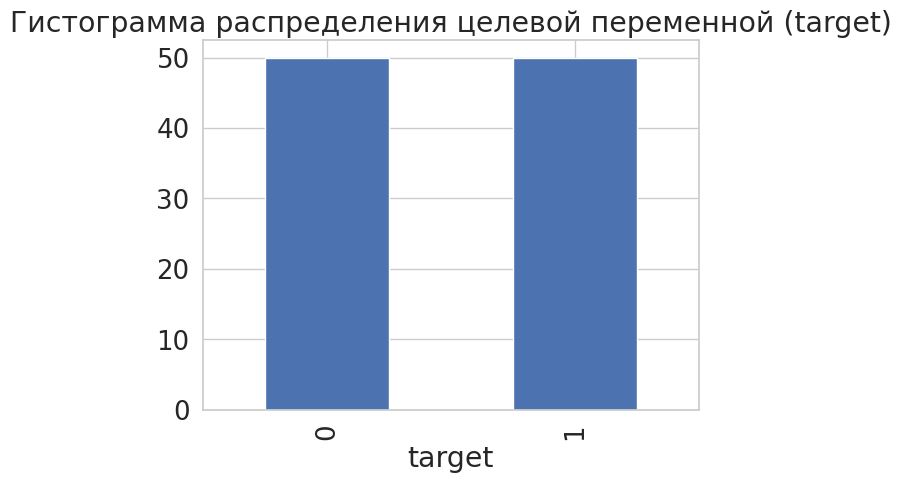

In [329]:
df['target'].value_counts().plot(kind='bar')
plt.title('Гистограмма распределения целевой переменной (target)')

*Разбиваем данные на тренировочную и тестовую части, размер тестовой части — 30%*

In [330]:
def split_data(X=X, y=y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    # Приеним стандартизацию только там где это необходимо.
    scaler=StandardScaler()
    columns=X_train.columns
    for col in columns:
      if (X_train[col] > 12).any():
        X_train[col]=scaler.fit_transform(X_train[[col]])
      if (X_test[col] > 12).any():
        X_test[col]=scaler.transform(X_test[[col]])

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test=split_data()
#X_train=scaler.fit_transform(X_train)
#X_test=scaler.transform(X_test)


# Строим модель классификаци - RandomForestClassifier, с параметрами "из коробки"

              precision    recall  f1-score   support

           0       1.00      0.80      0.89        15
           1       0.83      1.00      0.91        15

    accuracy                           0.90        30
   macro avg       0.92      0.90      0.90        30
weighted avg       0.92      0.90      0.90        30

Accuracy:  0.9
Precision:  0.8333333333333334
Recall:  1.0
F1-score:  0.9090909090909091
ROC AUC:  0.9


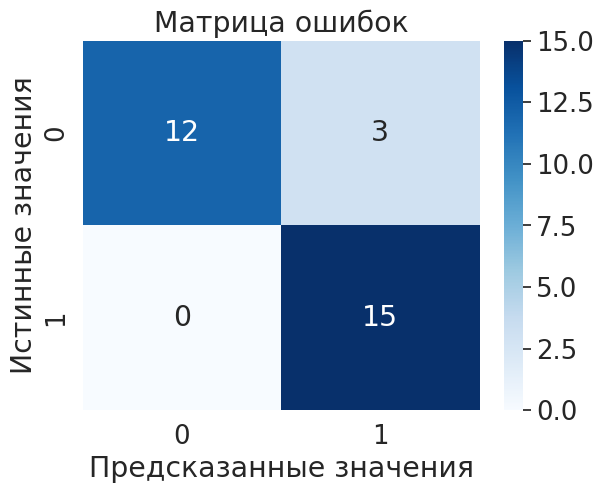

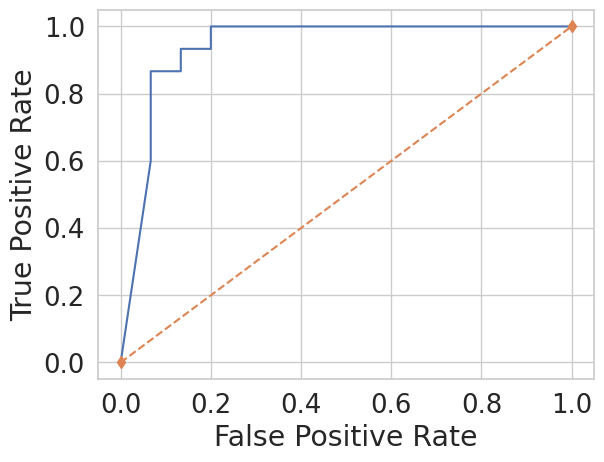

AUC: 0.940


In [331]:
def calculate_model(model=RandomForestClassifier(), X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    model.fit(X_train, y_train)
    y_pred=model.predict(X_test)
    print(classification_report(y_test, y_pred))
    print('Accuracy: ', accuracy_score(y_test, y_pred))
    print('Precision: ', precision_score(y_test, y_pred, average='binary'))
    print('Recall: ', recall_score(y_test, y_pred, average='binary'))
    print('F1-score: ', f1_score(y_test, y_pred, average='binary'))
    print('ROC AUC: ', roc_auc_score(y_test, y_pred))
    #Строим матрицу ошибок
    confusion_mat=confusion_matrix(y_test, y_pred)
    sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues')
    plt.title('Матрица ошибок')
    plt.xlabel('Предсказанные значения')
    plt.ylabel('Истинные значения')
    plt.show();
    #Предсказываем вероятности
    y_pred_proba=model.predict_proba(X_test)[:,1]
    # Строим кривую ROC
    fpr, tpr, thresholds1=roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label='RandomForestClassifier')
    plt.plot([0, 1], [0, 1], 'd--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show();
    print("AUC: %.3f" % roc_auc_score(y_test, y_pred_proba))
    return model

model1=calculate_model()

Хорошие метрики. Значения метрик близки к 0.9. Модель справилась хорошо.

*Показатель AUC (Area under Curve) - площади под кривой ROC - интерпретирует вероятность, с которой модель верно определит две точки (объекта), расположенные в разных классах, которые поданы ей на вход для анализа. В нашем случае это вероятность 89,6%. Показатель 50% (площадь под синей пунктирной кривой - вариант случайного выбора, рандомного угадывания).*

*Визуализируем важность признаков для предсказания целевого признака target:*

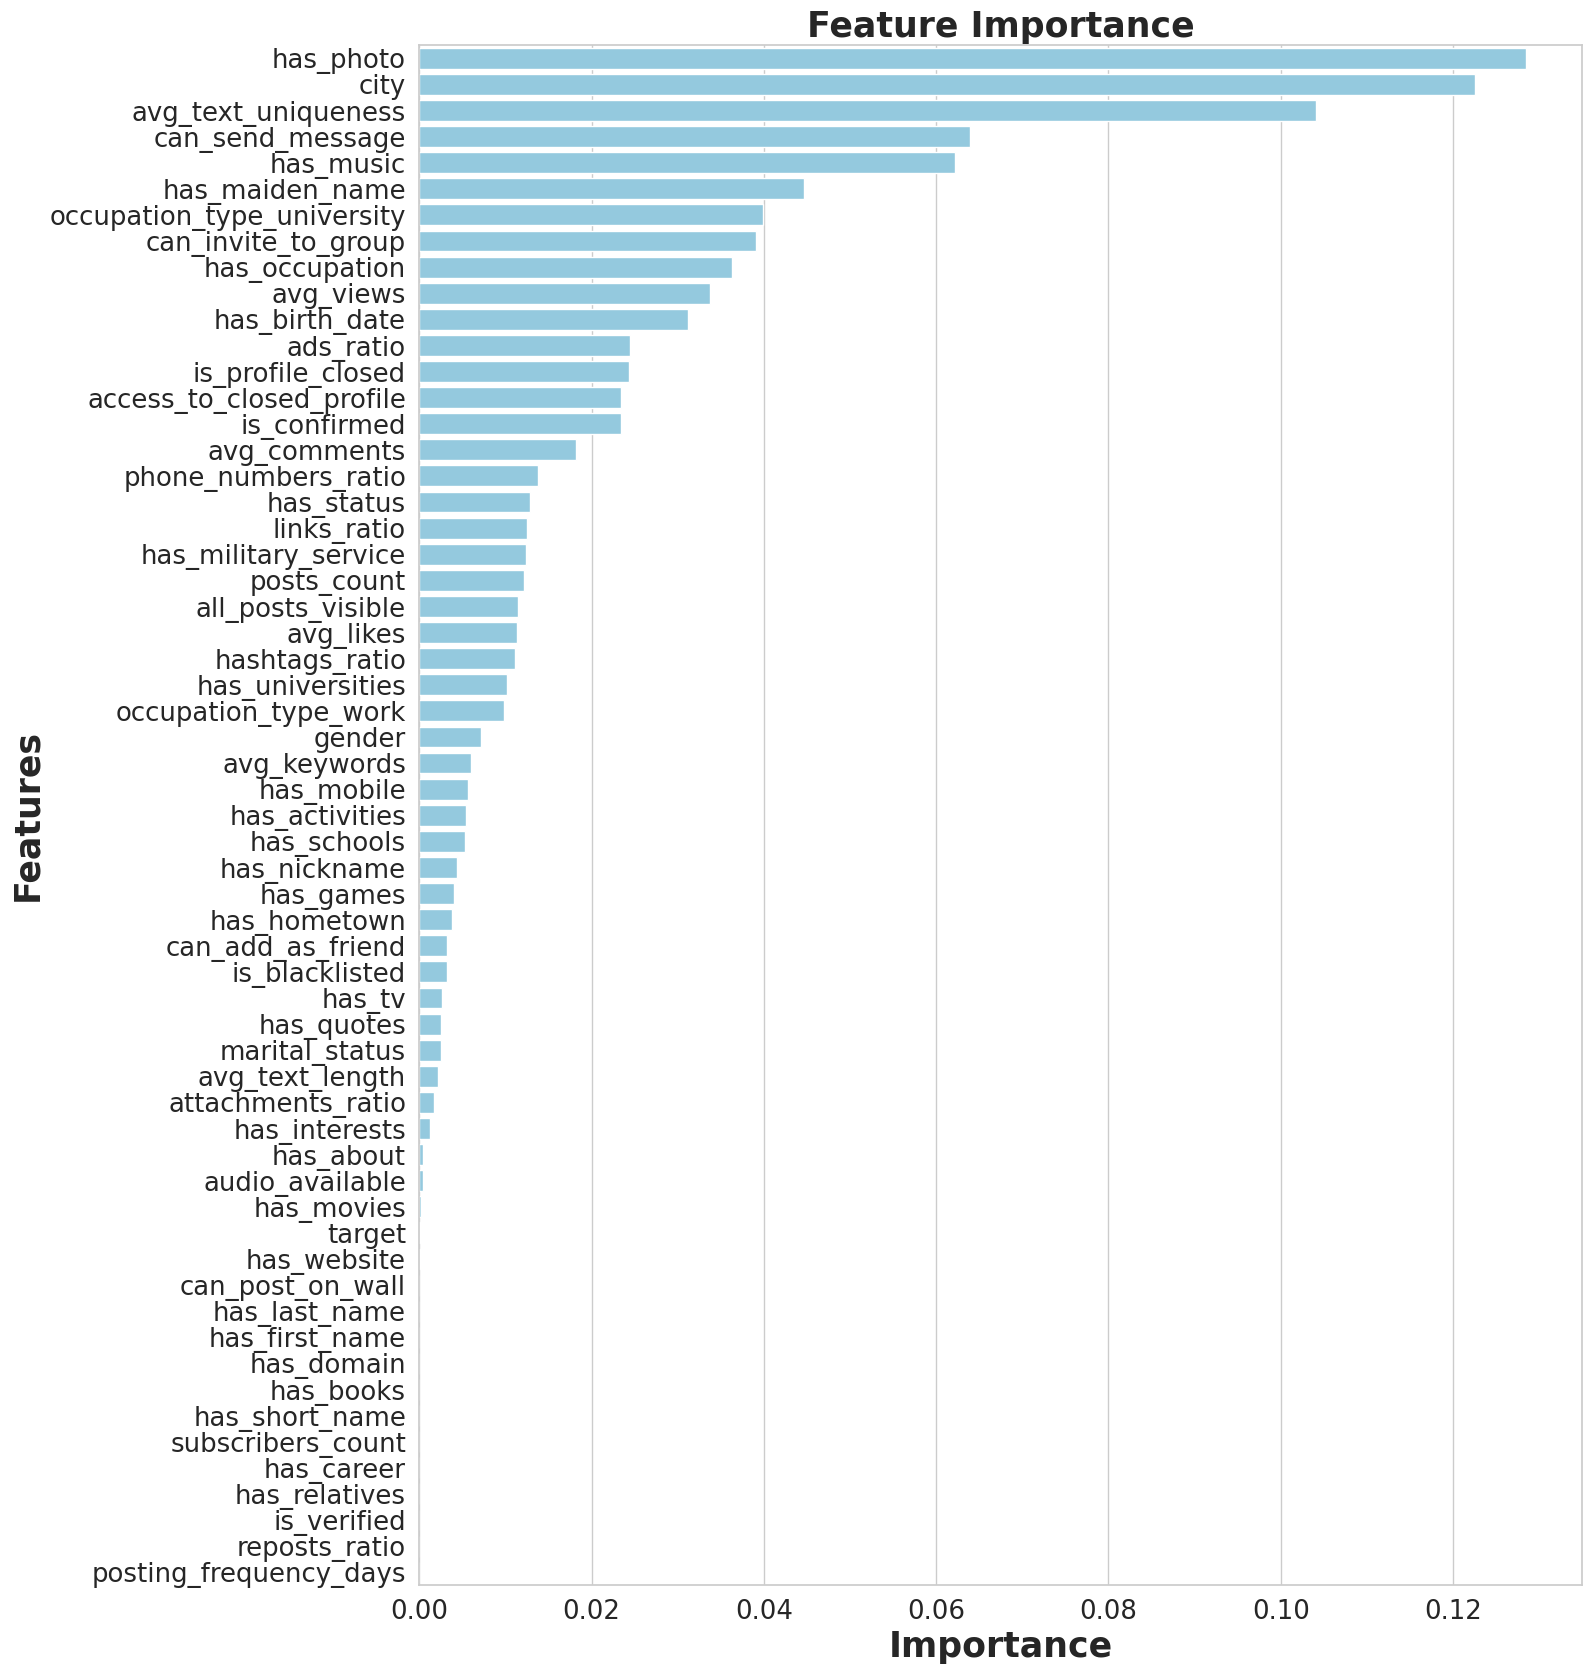

,Features,Gini-Importance
0,has_photo,0.128517
1,city,0.122504
2,avg_text_uniqueness,0.104055
3,can_send_message,0.063882
4,has_music,0.062196
5,has_maiden_name,0.044698
6,occupation_type_university,0.039930
7,can_invite_to_group,0.039039
8,has_occupation,0.036251
9,avg_views,0.033758


In [332]:

feats={}
for feature, importance in zip(df.columns, model1.feature_importances_):
      feats[feature]=importance
importances=(pd.DataFrame.from_dict(feats, orient='index')
                                  .rename(columns={0:'Gini-Importance'})
                                  .sort_values(by='Gini-Importance', ascending=False)
                                  .reset_index().rename(columns={'index': 'Features'}))

plt.figure(figsize=(15, 20))
sns.set(font_scale=5)
sns.set(style='whitegrid', color_codes=True, font_scale=1.7)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight='bold')
plt.ylabel('Features', fontsize=25, weight='bold')
plt.title('Feature Importance', fontsize=25, weight='bold')
plt.show();
display(importances)

*Часть признаков не оказывают существенного влияния на целевой параметр*


*Строим матрицу корреляций*

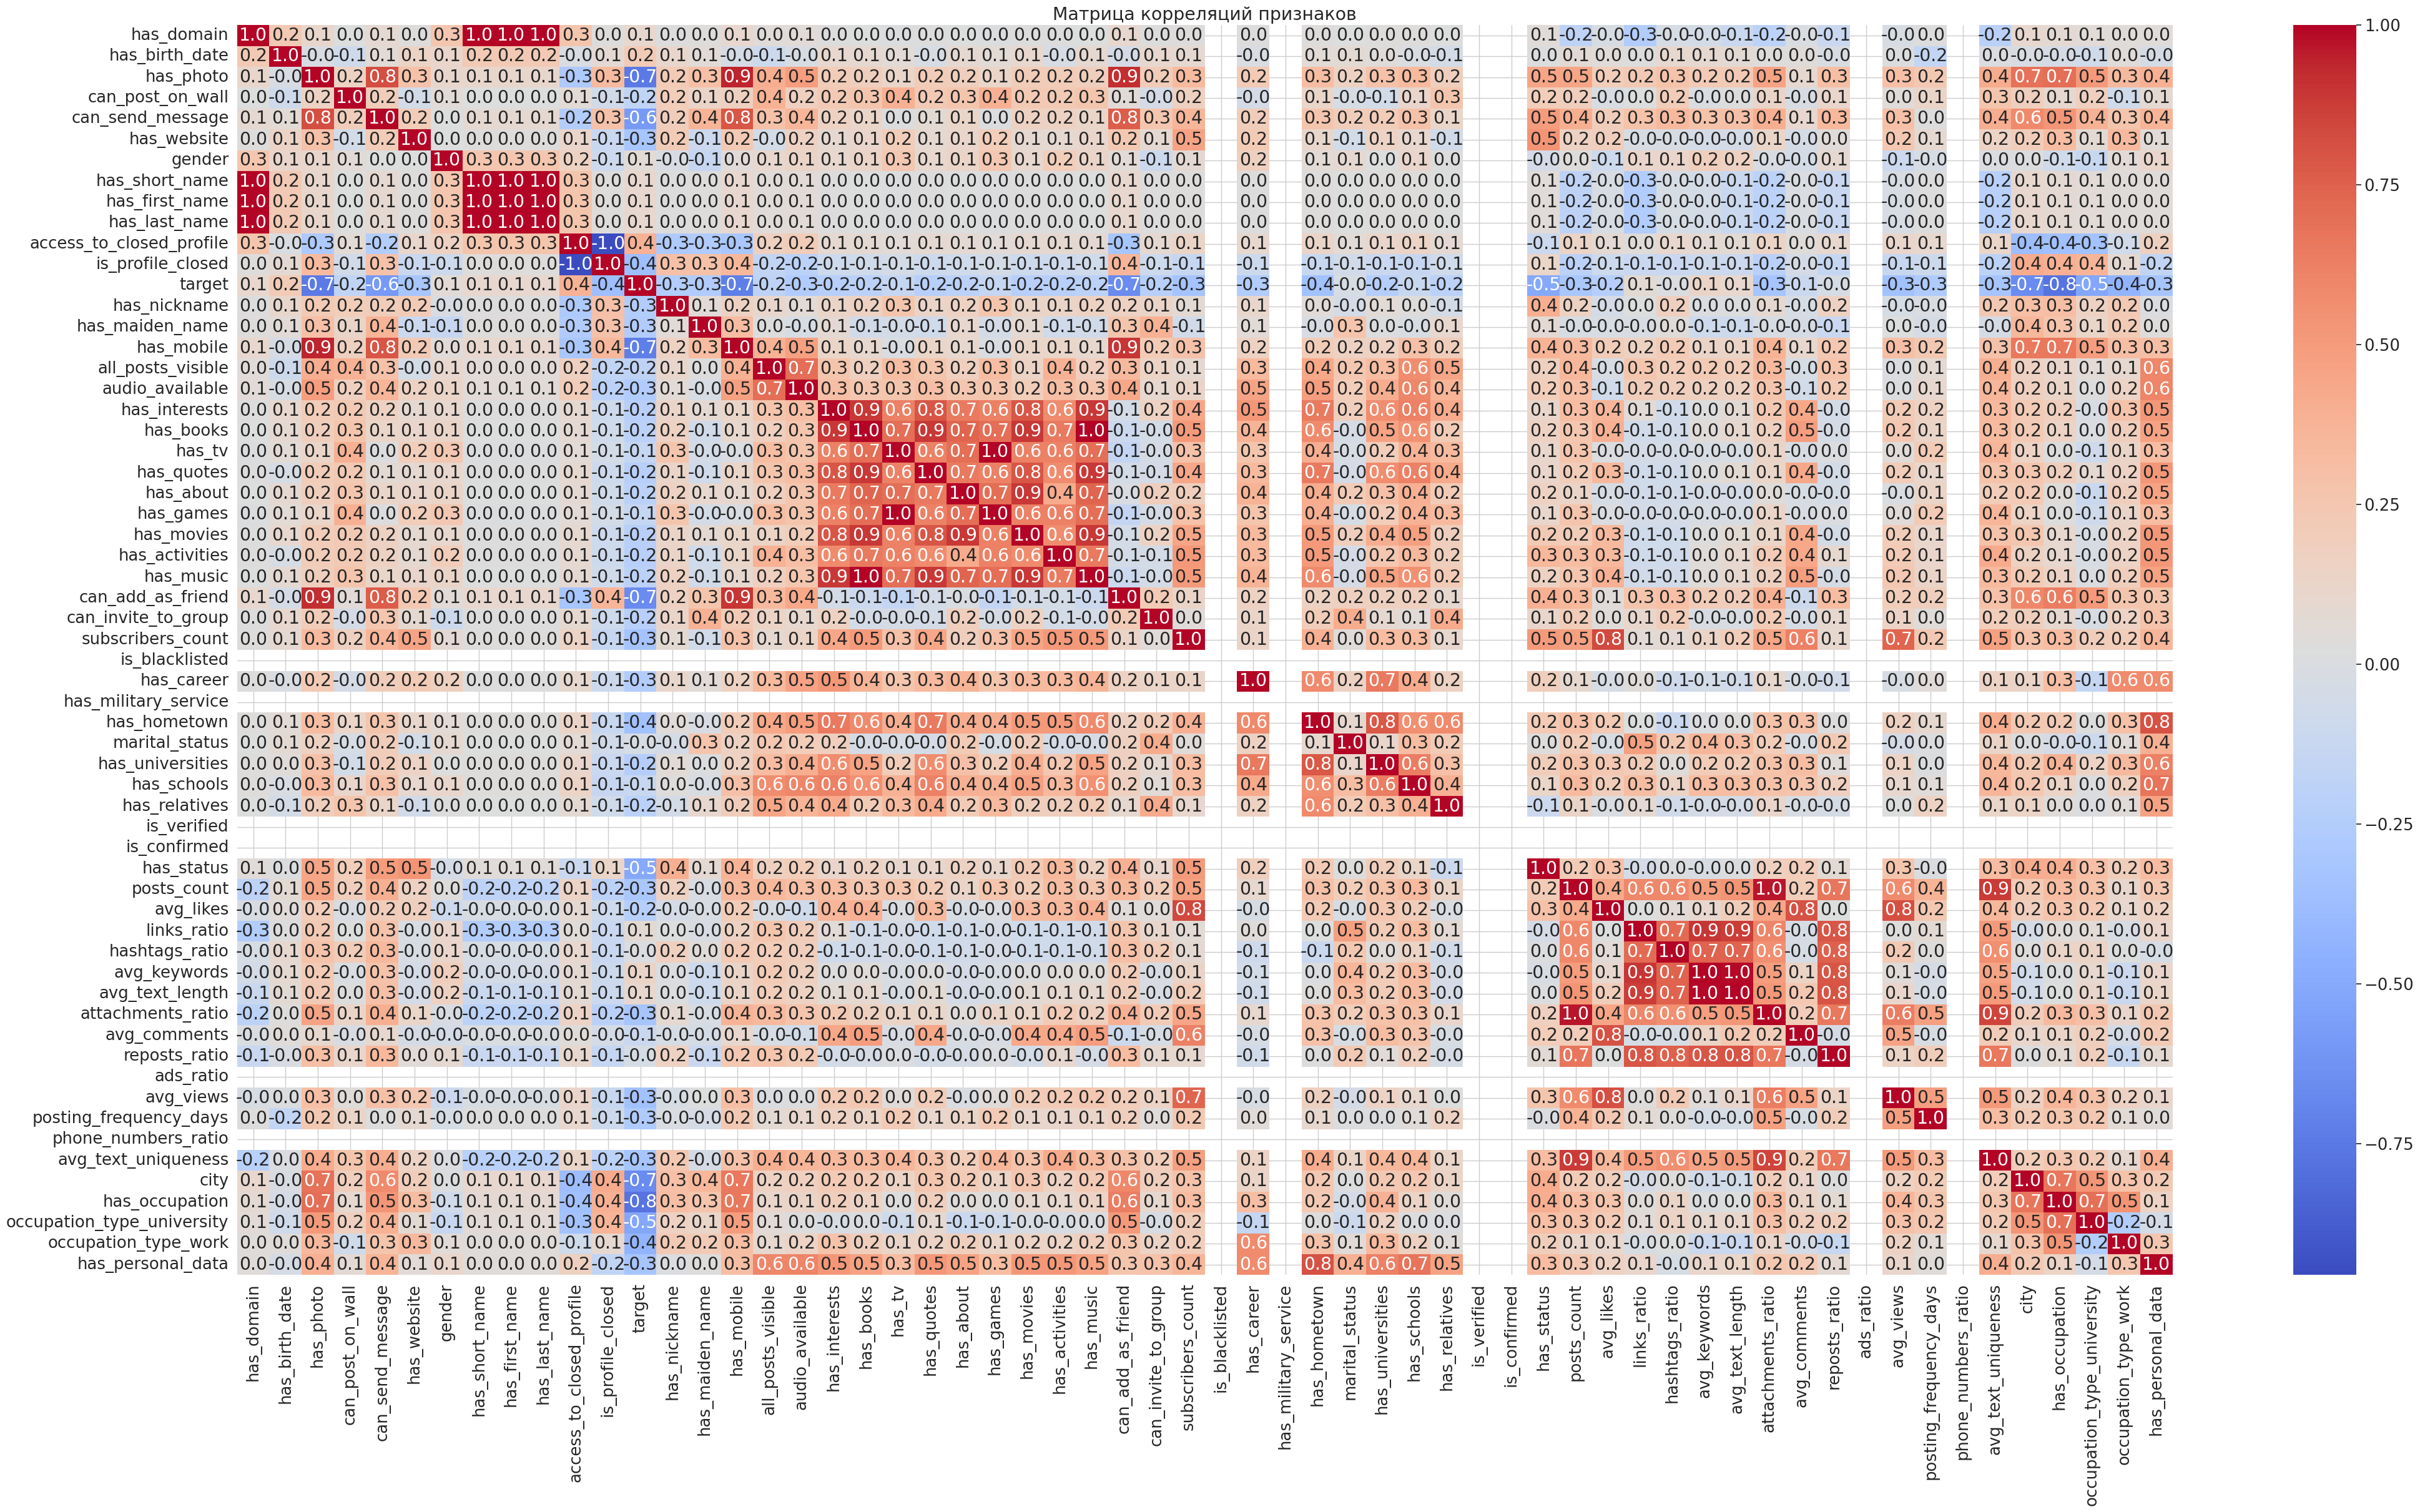

In [333]:
correlation_matrix=df.corr()
plt.figure(figsize=(50, 26))
sns.heatmap(correlation_matrix, annot=True, fmt=".1f",cmap='coolwarm')
plt.title('Матрица корреляций признаков')
plt.show();

Используйте метод кросс-валидации, чтобы оценить производительность модели на обучающей выборке. Например, можно использовать метод cross_val_score из библиотеки scikit-learn с использованием метрики оценки, такой как точность (accuracy) или среднеквадратичная ошибка (mean squared error).

In [334]:
# Функция для оценки модели с помощью перекрестной проверки
def evaluate_model(model, X_t, y_t, cv=5):
    scores = cross_val_score(model1, X_t, y_t, scoring='roc_auc', cv=cv)
    return scores.mean()

print('Roc Auc for train data:', evaluate_model(model1, X_train, y_train))
print('Roc Auc for test data:', evaluate_model(model1, X_test, y_test))

Roc Auc for train data: 0.9918367346938777
Roc Auc for test data: 0.9


Модель показала себя хорошо на тренеровачных и тестовых данных. Метрики F1 близки к 0.9.

*Видим, что некоторые признаки абсолютно коррелируют друг с другом*

*Нами была использована модель RandomForestClassifier с гиперпараметрами "по умолчанию". Применим алгоритм GridSearchCV для нахождения оптимальных гиперпараметров в построении нашей модели. В качестве критерия выберем максимизацию показателя AUC (ROC)*

In [335]:

# Поиск гиперпараметров с помощью сетки параметров
param_grid={
    'n_estimators': [70, 320],
    'max_depth': [2, 10, 12],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 3, 5]
}

grid_search = GridSearchCV(estimator=model1, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("Best parameters:", best_params)
print(f"Best score: {grid_search.best_score_:.2f}")

Best parameters: {'max_depth': 2, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 70}
Best score: 0.99


*Применим найденные гиперпараметры в построении модели*

              precision    recall  f1-score   support

           0       0.92      0.80      0.86        15
           1       0.82      0.93      0.88        15

    accuracy                           0.87        30
   macro avg       0.87      0.87      0.87        30
weighted avg       0.87      0.87      0.87        30

Accuracy:  0.8666666666666667
Precision:  0.8235294117647058
Recall:  0.9333333333333333
F1-score:  0.875
ROC AUC:  0.8666666666666668


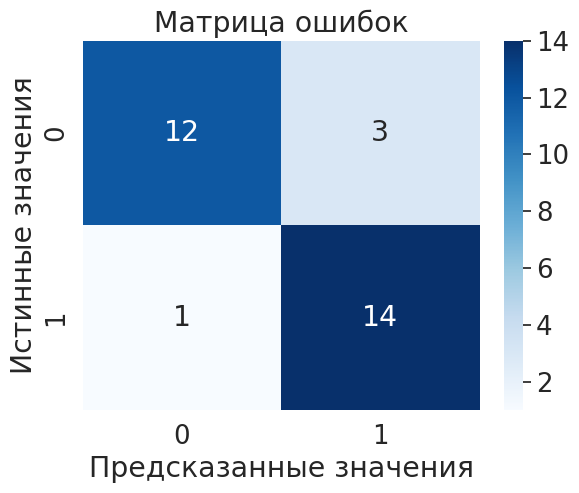

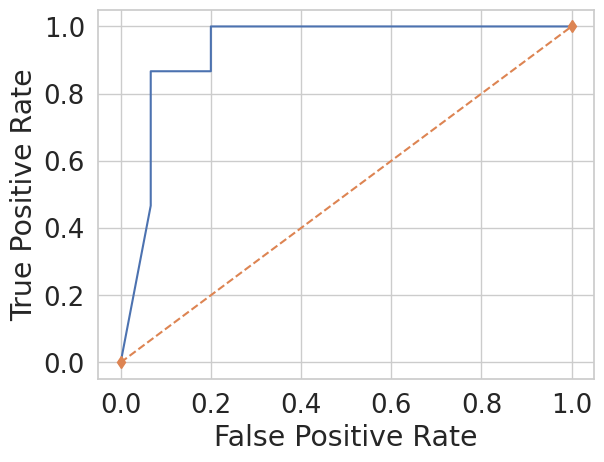

AUC: 0.931


In [336]:
model2=calculate_model(RandomForestClassifier(**best_params))

*Поиск гиперпараметров с помощью GridSearchCV не привел к улучшению метрик качества модели*

In [337]:
print("Среднее значение roc_auc по 5-кратной кросс-валидации:", evaluate_model(model2, X, y, 5))
print("Среднее значение roc_auc по 10-кратной кросс-валидации:", evaluate_model(model2, X, y, 10))

Среднее значение roc_auc по 5-кратной кросс-валидации: 0.961
Среднее значение roc_auc по 10-кратной кросс-валидации: 0.954


*При использовании кросс-валидации видим, что значение метрики (площадь под кривой ROC) не снижается, и немного растет, что свидетельствует о стабильности построенной нами модели и отсуствии переобучения при первичном построении.*

**Применим Recursive Feature Elimination (RFE) для выбора количества признаков**

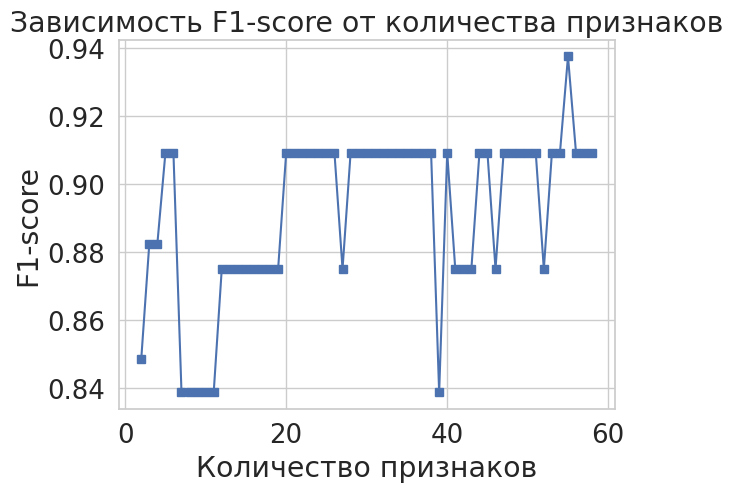

In [338]:
n_features=list(range(2, len(df.columns)-1))
metrics=[]
model3=RandomForestClassifier(random_state=42)
for k in n_features:
  rfe=RFE(model3, n_features_to_select=k)
  rfe.fit(X_train, y_train)
  X_train_rfe=rfe.transform(X_train)
  X_test_rfe=rfe.transform(X_test)
  model3.fit(X_train_rfe, y_train)
  y_pred=model3.predict(X_test_rfe)
  metrics.append(f1_score(y_test, y_pred, average='binary'))


plt.plot(n_features, metrics, marker='s')
plt.xlabel('Количество признаков')
plt.ylabel('F1-score')
plt.title('Зависимость F1-score от количества признаков')
plt.show();

Видим, что оптимальным является 6 признаков в модели. После этого метрика  F1 совершает колебания.

In [339]:
X_train.shape

(70, 59)

In [340]:
n_features=6
model4=RandomForestClassifier(**best_params, random_state=42)
rfe=RFE(model4, n_features_to_select=n_features)
rfe.fit(X_train, y_train)

RFE(estimator=RandomForestClassifier(max_depth=2, min_samples_leaf=2,
                                     n_estimators=70, random_state=42),
    n_features_to_select=6)

Выведем названия самых важных признаков

In [341]:
# Показываем какие признаки выбраны
selected_features=pd.DataFrame({
    'Feature': X.columns,
    'Ranking': rfe.ranking_
})
important_features=selected_features.sort_values(by='Ranking', ascending=False)[:n_features]
print(important_features)

             Feature  Ranking
0         has_domain       54
3   can_post_on_wall       53
8     has_first_name       52
9      has_last_name       51
5        has_website       50
12      has_nickname       49


              precision    recall  f1-score   support

           0       0.86      0.80      0.83        15
           1       0.81      0.87      0.84        15

    accuracy                           0.83        30
   macro avg       0.83      0.83      0.83        30
weighted avg       0.83      0.83      0.83        30

Accuracy:  0.8333333333333334
Precision:  0.8125
Recall:  0.8666666666666667
F1-score:  0.8387096774193549
ROC AUC:  0.8333333333333334


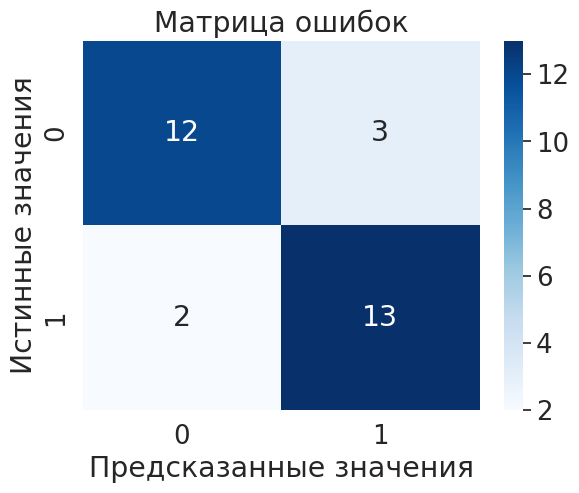

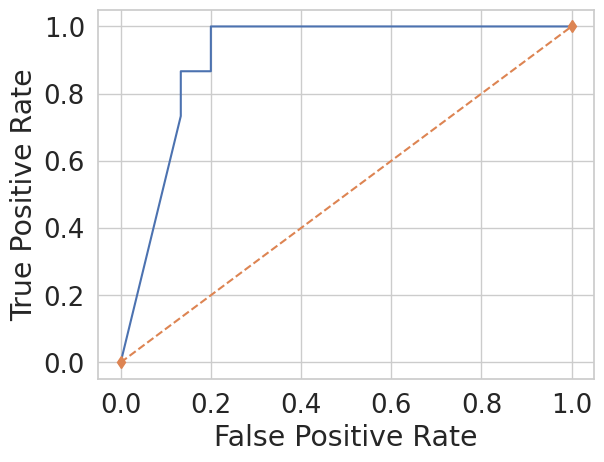

AUC: 0.907


RandomForestClassifier(max_depth=2, min_samples_leaf=2, n_estimators=70,
                       random_state=42)

In [342]:
X_train_rfe=rfe.transform(X_train)
X_test_rfe=rfe.transform(X_test)
calculate_model(model=model4, X_train=X_train_rfe, X_test=X_test_rfe, y_train=y_train, y_test=y_test)

*Видим, что при таком количестве признаков качество модели практически не ухудшилось*

**В настоящей работе мы применили классификацию с помощью модели RandomForestClassifier "из коробки", попробовали улучшить метрики качества при помощи подбора гиперпараметров GridSearchCV - убедились, что в случае с RandomForestClassifier модель дает хорошие метрики даже с параметрами по умолчанию. С помощью кросс-валидации убедились в том, что модель не склонна к переобучению. С применением Recursive Feature Elimination нашли, что для модели достаточно оставить 6 из 59 признаков - качество модели от этого практически не ухудшается**.

## Проверим нашу модель RandomForestClassifier на полных данных

In [343]:
df_real.head()

,has_domain,has_birth_date,has_photo,can_post_on_wall,can_send_message,has_website,gender,has_short_name,has_first_name,has_last_name,...,ads_ratio,avg_views,posting_frequency_days,phone_numbers_ratio,avg_text_uniqueness,city,has_occupation,occupation_type_university,occupation_type_work,has_personal_data
0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
1,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
2,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
3,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
4,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0


In [344]:
df_real.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5874 entries, 0 to 5873
Data columns (total 60 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   has_domain                  5874 non-null   float64
 1   has_birth_date              5874 non-null   float64
 2   has_photo                   5874 non-null   float64
 3   can_post_on_wall            5874 non-null   float64
 4   can_send_message            5874 non-null   float64
 5   has_website                 5874 non-null   float64
 6   gender                      5874 non-null   float64
 7   has_short_name              5874 non-null   float64
 8   has_first_name              5874 non-null   float64
 9   has_last_name               5874 non-null   float64
 10  access_to_closed_profile    5874 non-null   float64
 11  is_profile_closed           5874 non-null   float64
 12  target                      5874 non-null   int64  
 13  has_nickname                5874 

In [345]:
X=df_real.drop('target', axis=1)
y=df_real['target']
df_real['target'].value_counts()

,count
target,
1,2937
0,2937


In [346]:
X_train, X_test, y_train, y_test=split_data(X=X, y=y)

In [347]:
display(model4)

RandomForestClassifier(max_depth=2, min_samples_leaf=2, n_estimators=70,
                       random_state=42)

In [349]:
model4.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 2,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 70,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

              precision    recall  f1-score   support

           0       0.88      0.96      0.92       882
           1       0.96      0.88      0.91       881

    accuracy                           0.92      1763
   macro avg       0.92      0.92      0.92      1763
weighted avg       0.92      0.92      0.92      1763

Accuracy:  0.9171866137266024
Precision:  0.9553903345724907
Recall:  0.8751418842224744
F1-score:  0.9135071090047393
ROC AUC:  0.9171627788459311


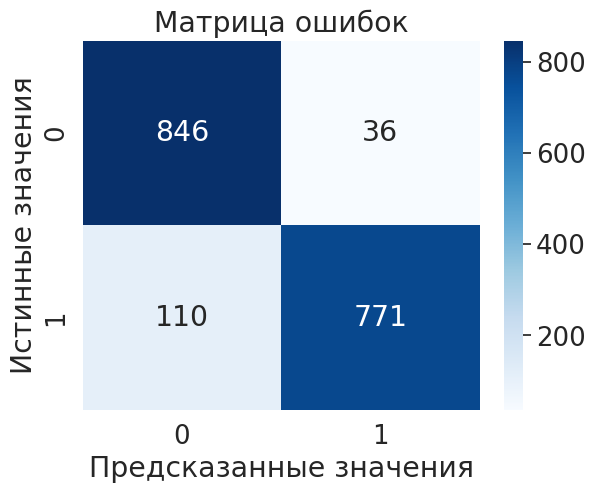

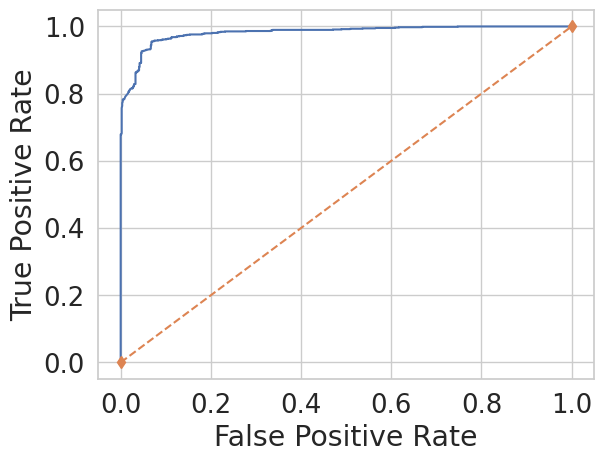

AUC: 0.982


RandomForestClassifier(max_depth=2, min_samples_leaf=2, n_estimators=70,
                       random_state=42)

In [348]:
calculate_model(model=model4, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)

Удалось достичь высоких метрик модели на полном наборе данных F1_score=0.913, несмотря на то что для построения модели RandomForestClassifier мы брали только 100 случайных строк исходного DataSet. У нас получилось потому, что данные целевой переменной идеально сбалансированы 50%/50%.